<a href="https://colab.research.google.com/github/epv44/rent-vs-buy/blob/main/Mortgage_Cost_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Constants

In [142]:
import math
from dataclasses import dataclass
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List

pd.set_option('float_format', '{:,}'.format)

In [143]:
@dataclass
class MortgageData:
    principle_paid: float
    mortgage_interest: float
    projected_home_value: float
    # money made from sale of the home minus mortgage costs (doesn't take into account downpayment)
    net_profit_from_home_sale: float
    loan_balance: float
    cash_reserve: float
    # growth of net worth over time after home sale
    net_worth_after_sale: float
    # roi towards your net worth
    roi_net_worth: float
    # roi on the home purchase itself
    roi: float
    # money made after subtracting downpayment
    net_profit: float
    rental_cost: float
    net_worth_if_renting: float
    ds: date

Derived Monthly Expenses

In [144]:
# yearly interest rate per month
def ownership_costs(
    home_price: float,
    downpayment: float,
    mortgage_interest_rate: float,
    loan_term: float,
    closing_cost_percentage: float,
    property_tax_rate: float,
    should_add_closing_to_loan: bool,
    monthly_pmi: float,
    monthly_hoa: float,
    monthly_insurance: float,
    monthly_maintenance_fund: float,
) -> Tuple[float, float, float]:
  periodic_interest_rate = mortgage_interest_rate / 12
  payment_periods = loan_term * 12
  loan_amount = home_price - downpayment
  # https://www.nerdwallet.com/article/mortgages/closing-costs-mortgage-fees-explained
  closing_costs = loan_amount * closing_cost_percentage
  down_plus_closing = downpayment + closing_costs
  if should_add_closing_to_loan:
    mortgage = (home_price + closing_costs) - downpayment
  else:
    mortgage = home_price - downpayment
  monthly_mortgage = mortgage / (
      ((1 + periodic_interest_rate) ** (payment_periods) - 1)
      / ((periodic_interest_rate) * (1 + periodic_interest_rate) ** (payment_periods))
  )

  monthly_property_tax = home_price * (property_tax_rate/12)

  monthly_operating_expenses = (
      monthly_pmi
      + monthly_hoa
      + monthly_insurance
      + monthly_maintenance_fund
      + monthly_mortgage
      + monthly_property_tax
  )

  return monthly_operating_expenses, monthly_mortgage, down_plus_closing

Monthly Payment Calculation

In [145]:
def calculate_monthly_cost_and_loan_balance(
    monthly_operating_expenses: float,
    down_plus_closing: float,
    monthly_mortgage: float,
    loan_term: float,
    mortgage_interest_rate: float,
    downpayment: float,
    home_price: float,
    property_appreciation: float,
    starting_cash: float,
    realtor_fee_at_sale: float,
    capital_gains_tax: float,
    monthly_rent: float,
    rental_increase_pct: float,
    stock_interest_rate: float,
    monthly_income_saved: float,
    yearly_increase: float,
    purchase_date: date,
) -> List[MortgageData]:

  periodic_interest_rate = mortgage_interest_rate / 12
  payment_periods = loan_term * 12
  loan_amount = home_price - downpayment
  loan_balance = loan_amount
  projected_home_value = home_price
  data = []

  cash_reserve = starting_cash - down_plus_closing

  # rental params
  cash_reserve_rental = starting_cash
  rental_cost_monthly = monthly_rent
  monthly_savings = monthly_income_saved

  # zero indexed subtracting 1 from payment periods
  for row in range(0, (int(payment_periods))):
    principle_paid = monthly_mortgage - loan_balance * (
        periodic_interest_rate
        * (1 + periodic_interest_rate) ** (payment_periods)
        / ((1 + periodic_interest_rate) ** (payment_periods - 1))
        )
    mortgage_interest = monthly_mortgage - principle_paid
    projected_home_value = home_price * (1+property_appreciation)**(row/12)
    # if selling at a loss vs. gain
    if projected_home_value - home_price - projected_home_value * realtor_fee_at_sale > 0:
      net_profit_at_sale = (projected_home_value * (1 - realtor_fee_at_sale) - loan_balance) - (
          (projected_home_value - home_price) - projected_home_value * realtor_fee_at_sale
          ) * capital_gains_tax
    else:
      net_profit_at_sale = projected_home_value * (1 - realtor_fee_at_sale) - loan_balance

    net_worth_after_sale = net_profit_at_sale + cash_reserve # - down_plus_closing
    net_profit = net_profit_at_sale # - down_plus_closing
    roi = net_profit / down_plus_closing
    roi_net_worth = (net_profit + cash_reserve) / (down_plus_closing)
    ds = purchase_date + relativedelta(months=row+1)

    # yearly rent increase
    if row % 12 == 0:
      rental_cost_monthly = rental_cost_monthly * (1 + rental_increase_pct)

    data.append(MortgageData(
        principle_paid,
        mortgage_interest,
        projected_home_value,
        net_profit_at_sale,
        loan_balance,
        cash_reserve,
        net_worth_after_sale,
        roi_net_worth,
        roi,
        net_profit,
        rental_cost_monthly,
        cash_reserve_rental,
        ds
      )
    )

    monthly_savings = monthly_income_saved * (1 + yearly_increase)**(row/12)

    cash_reserve_rental = cash_reserve_rental * (1+(stock_interest_rate/12)) + monthly_savings - rental_cost_monthly
    cash_reserve = cash_reserve * (1+(stock_interest_rate/12)) + monthly_savings - monthly_operating_expenses

    loan_balance = loan_balance - principle_paid

  return data

In [146]:
# shared inputs
home_price = 1700000.0
downpayment = 800000.0
mortgage_interest_rate = .065
loan_term = 30

# calculations
monthly_operating_expenses, monthly_mortgage, down_plus_closing = ownership_costs(
    home_price=home_price,
    downpayment=downpayment,
    mortgage_interest_rate=mortgage_interest_rate,
    loan_term=loan_term,
    closing_cost_percentage=.025,
    property_tax_rate=.011,
    should_add_closing_to_loan=False,
    monthly_pmi=0.0,
    monthly_hoa=450,
    monthly_insurance=490,
    monthly_maintenance_fund=200,
)

data = calculate_monthly_cost_and_loan_balance(
    monthly_operating_expenses=monthly_operating_expenses,
    down_plus_closing=down_plus_closing,
    monthly_mortgage=monthly_mortgage,
    loan_term=loan_term, # 30, 15, 5 year. Assume fixed rate for now
    mortgage_interest_rate=.065,
    downpayment=downpayment,
    home_price=home_price,
    property_appreciation=.04,
    starting_cash=1200000.0,
    realtor_fee_at_sale=.06,
    capital_gains_tax=.3,
    monthly_rent=6500,
    rental_increase_pct=.036,
    stock_interest_rate=.06,
    monthly_income_saved=6000,
    yearly_increase=.02, # in amount saved
    purchase_date=date(2024, 8, 1)
)


df = pd.DataFrame([vars(s) for s in data])
display(df)

,principle_paid,mortgage_interest,projected_home_value,net_profit_from_home_sale,loan_balance,cash_reserve,net_worth_after_sale,roi_net_worth,roi,net_profit,rental_cost,net_worth_if_renting,ds
0,787.2059614366872,"4,901.406250000001","1,700,000.0","698,000.0","900,000.0","377,500.0","1,075,500.0",1.307598784194529,0.8486322188449849,"698,000.0","6,734.0","1,200,000.0",2024-09-01
1,791.49309056938,"4,897.119120867308","1,705,565.357629738","704,018.6421333903","899,212.7940385633","377,000.5544552299","1,081,019.19658862",1.3143090536031854,0.8559497168795018,"704,018.6421333903","6,734.0","1,205,265.9999999998",2024-10-01
2,795.8035674371004,"4,892.808643999588","1,711,148.934792151","710,058.6977566279","898,421.3009479939","376,508.52117054746","1,086,567.2189271753",1.3210543695163226,0.8632932495521312,"710,058.6977566279","6,734.0","1,210,568.2394878112",2024-11-01
3,800.1375191917768,"4,888.474692244911","1,716,750.791133247","716,120.2462846953","897,625.4973805568","376,023.953573578","1,092,144.1998582734",1.3278348934447093,0.870662913416043,"716,120.2462846953","6,734.0","1,215,906.916027198",2024-12-01
4,804.4950736778064,"4,884.117137758882","1,722,370.9864943014","722,203.3674432783","896,825.3598613649","375,546.905386115","1,097,750.2728293934",1.3346507876345208,0.8780588054021621,"722,203.3674432783","6,734.0","1,221,282.2281967732",2025-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,"5,413.0985281629455",275.5136832737426,"5,424,402.102579701","4,028,666.5482506463","50,590.03524679649","1,348,434.6481132281","5,377,101.196363875",6.537509053329939,4.898074830699874,"4,028,666.5482506463","18,780.451067968137","4,562,019.125910087",2054-04-01
356,"5,442.578300338282",246.03391109840595,"5,442,160.18353756","4,045,764.4640490804","45,176.936718633544","1,357,568.7399579093","5,403,333.2040069895",6.56940207174102,4.918862570272438,"4,045,764.4640490804","18,780.451067968137","4,576,827.634620553",2054-05-01
357,"5,472.218619557608",216.3935918790803,"5,459,976.3998315055","4,062,930.1126708356","39,734.35841829526","1,366,766.3044322983","5,429,696.417103134",6.601454610459737,4.939732659782171,"4,062,930.1126708356","18,780.451067968137","4,591,727.988045056",2054-06-01
358,"5,502.020360161237",186.59185127545152,"5,477,850.9417815","4,080,163.7798934896","34,262.139798737655","1,376,027.6883012753","5,456,191.468194765",6.633667438534669,4.9606854466790145,"4,080,163.7798934896","18,780.451067968137","4,606,720.674808898",2054-07-01


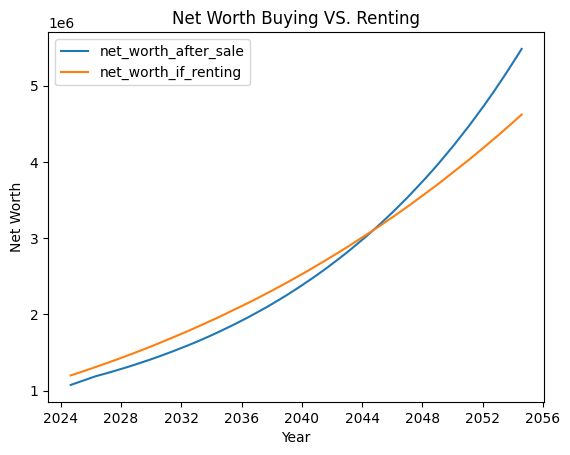

In [147]:
plt.plot('ds', 'net_worth_after_sale', data=df)
plt.plot('ds', 'net_worth_if_renting', data=df)
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('Net Worth')
plt.title('Net Worth Buying VS. Renting')
plt.show()

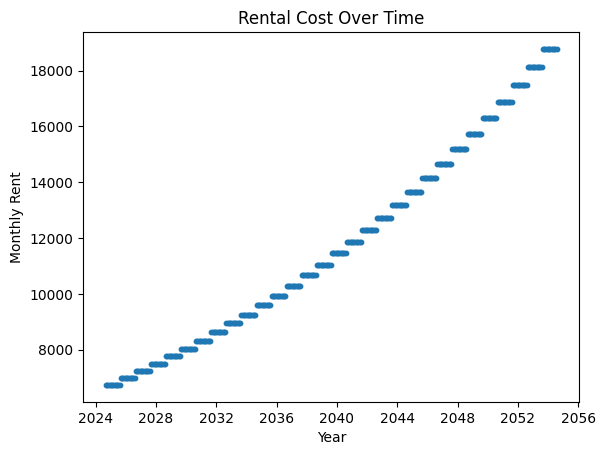

In [148]:
plt.scatter('ds', 'rental_cost', data=df, s=10)
plt.xlabel('Year')
plt.ylabel('Monthly Rent')
plt.title('Rental Cost Over Time')
plt.show()